# Playing with the FERC small generators table

This notebook takes the header rows interspersed throughout the data and turns them into actual headers rather than rows with NAN values. In the final output, the columns `manual_map` refers to the column
previously called `plant_type` that was manually mapped by zane. The column called `headers` is the new
column that maps these values programatically.

To compare the programatic mapping against the manual mapping, I created a dictionary that mirrors the type of fuel labels used by Zane in the manual map. You can decide whether to use this one (for compariative
purposes) or another generic one for other (rmi) purposes.

The final `assign_headers_all()` function allows you to not `drop_headers` if you want. This is a good way to check the efficacy of the programatic header mapping. Otherwise, it will automatically remove all of the
header rows from the data along with any of the support columns created along the way.

## Setup...

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Standard libraries
import pathlib
import sys
import random

# 3rd party libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa


# Local libraries
import pudl
from pudl.analysis.fill_ferc1_fuel_gaps import *
from pudl.analysis.flag_ferc1_totals import *

# Enable viewing of logging outputs
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# Display settings
sns.set()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 75
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
# makes notebooks full-width. Unnecessary for lab.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# Establish connection to pudl database
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine,
    freq='AS'
)

ferc_engine = sa.create_engine(pudl_settings['ferc1_db'])

In [6]:
small_plants_raw = pd.read_sql("f1_gnrt_plant", ferc_engine)
small_plants = pudl_out.plants_small_ferc1()#.dropna(subset=['plant_name_ferc1'])

In [7]:
# View random utility groups! (thanks, Trenton)
def view_random_utility(df):
    df = df.reset_index(drop=True)
    util_groups = df.groupby(['utility_id_ferc1'])
    random_utility = random.choice(list(util_groups.groups.keys()))
    return df.iloc[util_groups.groups[random_utility]]

## Use Zane's transformations without dropping the NA rows...

In [144]:
# Here we create a fake raw dfs dictionary with just the small plants df to run it through
# Zane's existing transform feature.
fake_dict = {'plants_small_ferc1': small_plants_raw}
new_dict = {}
small_plants_dict = pudl.transform.ferc1.plants_small(fake_dict, new_dict)
small_plants_out = small_plants_dict['plants_small_ferc1']

# drop rows with no plant name because we can't use that
small_plants_out = small_plants_out.dropna(subset=['plant_name_original'])

/home/tpb/miniconda3/envs/pudl_ml/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [145]:
# check size
print(small_plants_out.shape, small_plants_raw.shape)

(19559, 18) (19559, 31)


## Get rid of rows we know we won't need...

In [10]:
# If these columns are nan, we can assume it is either a header row or isn't useful
nan_cols = ['construction_year', 'net_generation_mwh', 'total_cost_of_plant', 'capex_per_mw', 'opex_total', 
            'opex_fuel', 'opex_maintenance', 'fuel_cost_per_mmbtu']

In [146]:
# Remove utilities with all NAN rows because these won't contain anything meaningful
# spc = small_plants_clean
spc = (
    small_plants_out
    .groupby('utility_id_ferc1').filter(lambda x: ~x[nan_cols].isna().all().all())
)

In [114]:
# Remove rows with ---------- or '' for names
spc = spc[~spc['plant_name_original'].str.contains('------')]
spc = spc[~spc['plant_name_original'].isin(['', 'none', 'na', 'n/a', 'not applicable'])]
spc = spc.reset_index(drop=True)

## Flag total rows...

In [119]:
spc.insert(3, 'is_total', False)
spc.loc[spc['plant_name_original'].str.contains('total'), 'is_total'] = True

## Flag possible headers...

In [21]:
# If a potential header column has these strings, it's probably a useful header
header_strings = ['hydro', 'hyrdo', 'internal', 'wind', 'solar', 'gas', 'diesel', 'diesal', 
                  'steam', 'other', 'combustion', 'combustine', 'fuel cell', 'hydraulic', 
                  'waste', 'landfill', 'photovoltaic', 'nuclear', 'oil', 'renewable', 
                  'facilities']

# If a potential header has these strings, it's not a header...
exclude = ['license', '#', '\*', 'pg', 'solargenix', '\@']

# ...unless it also has one of these strings
exceptions = ['hydro plants: licensed proj. no.', 'hydro license no.', 
              'hydro: license no.', 'hydro plants: licensed proj no.']

# What we will rename the headers once we remove them as rows 
new_header_labels = {
    'hydroelectric': ['hydro', 'hyrdo'],
    'internal combustion': ['internal', 'interal', 'international combustion', ],
    'combustion turbine': ['combustion turbine'],
    'gas turbine': ['gas'],
    'petroleum liquids': ['oil', 'diesel', 'diesal'],
    'solar': ['solar', 'photovoltaic'],
    'wind': ['wind'],
    'geothermal': ['geothermal'],
    'waste': ['waste', 'landfill'],
    'steam': ['steam'],
    'nuclear': ['nuclear']
}

# Header names that match the one's that zane used in his manual mapping (so we can 
# compare processes)
zane_header_labels = {
    'solar_pv': ['solar', 'photovoltaic'],
    'wind': ['wind'],
    'hydro': ['hydro', 'hyrdo'],
    'internal_combustion': ['internal', 'interal', 'international combustion', ],
    'combustion turbine': ['combustion turbine', 'combustine turbine'],
    'diesel_turbine': ['oil', 'diesel', 'diesal'],
    'gas_turbine': ['gas'],
    'geothermal': ['geothermal'],
    'waste_heat': ['waste', 'landfill'],
    'steam_heat': ['steam'],
    'nuclear': ['nuclear'],
    'fuel_cell': ['fuel cell']
}

In [22]:
# Add some new columns
spc.insert(3, 'is_header', False)
spc.insert(3, 'header_type', np.nan)

# Label possible header rows (based on the nan cols specified above)
spc.loc[spc.filter(nan_cols).isna().all(1), 'is_header'] = True

# Label good header rows (based on whether they contain key strings)
is_header = spc['is_header']
is_good_header = spc['plant_name_original'].str.contains('|'.join(header_strings))
not_bad = ~spc['plant_name_original'].str.contains('|'.join(exclude))

spc.loc[is_header & is_good_header & not_bad, 'header_type'] = 'good_header'
spc.loc[spc['plant_name_original'].isin(exceptions), 'header_type'] = 'good_header'

## Get rid of large clumps of notes or bad headers...

In [23]:
from pudl.analysis.fill_ferc1_fuel_gaps import * 

def get_header_clumps_all(df):
    """
    Remove clumps of consecutive rows flagged as possible headers.
    
    FERC has lots of note rows that are not headers but are also not useful for analysis.
    This function looks for rows flagged as possible headers (based on NAN values) and checks to
    see if there are multiple in a row. A header row is (usually) defined as a row with NAN values
    followed by rows without NAN values, so when there are more than one clumped together they are
    likely either notes or note helpful. There is one exception to this case which is a header that 
    is followed by a plant that had no values reported... Unfortunately I haven't built a work around,
    but hopefully there aren't very many of these. Currently, that header and plant will be categorized
    as clumps and removed.
    
    Sometimes note clumps will end with a meaningful header. This function also checks for this and will
    unclump any headers at the bottom of clumps.
    
    """
    util_groups = df.groupby(['utility_id_ferc1', 'report_year'])
    
    def get_header_clumps(util_year_group):
        #Create mini groups that count pockets of true and false for each utility and year
        # create_groups() is a function from the fill_ferc1_fuel_gaps module-- basically what
        # it does is create a df where each row represents a clump of adjecent, equal values for
        # a given column. Ex: a column of True, True, True, False, True, False, False, will
        # appear as True, False, True, False with value counts for each
        group, header_count = create_groups(util_year_group, 'is_header')
        
        # These are used later to enable exceptions
        max_idx_val = header_count.index.max()
        max_df_val = util_year_group.index.max()
        
        # Create a list of the index values that comprise each of the header clumps
        # It's only considered a clump if it is greater than 1.
        idx_list = list(header_count[
            (header_count['fuel']) & (header_count['val_count'] > 1)].index)
        
        # If the last row is not a clump (i.e. there is just one value) but it is a header (i.e. has nan values)
        # then also include it in the index values to be flagged because it might be a one-liner note. And
        # because it is at the bottom there is no chance it can actually be a useful header because there are
        # no value rows below it.
        last_row = header_count.tail(1)
        if (last_row['fuel'].item()) & (last_row['val_count'].item()==1):
            idx_list = idx_list + list(last_row.index)
        # If there are any clumped/end headers:
        if idx_list:
            for idx in idx_list:
                # Check to see if last clump bit is not a header... sometimes you might find a clump of
                # notes FOLLOWED by a useful header. This next bit will check the last row in each of
                # the identified clumps and "unclump" it if it looks like a valid header. We only need
                # to check clumps that fall in the middle because, as previously mentioned, the last row
                # cannot contain any meaningful header information because there are no values below it.
                idx_range = group.groups[idx+1]
                is_middle_clump = group.groups[idx+1].max() < max_df_val
                is_good_header = util_year_group.loc[
                    util_year_group.index.isin(group.groups[idx+1])].tail(1)['plant_name_original'].str.contains('|'.join(header_strings)).all()  #.isin(header_strings).all()
                # If the clump is in the middle and the last row looks like a header, then drop it from the idx range
                if is_middle_clump & is_good_header:
                    idx_range = [x for x in idx_range if x != idx_range.max()]
                # Label the clump as a clump
                util_year_group.loc[
                    util_year_group.index.isin(idx_range), 'header_type'] = 'clump'
        return util_year_group
    
    return util_groups.apply(lambda x: get_header_clumps(x))

In [24]:
header_clumps = get_header_clumps_all(spc)

In [25]:
# List of things that don't make the cut as headers
bad_headers = list(
    header_clumps[
        (header_clumps['is_header']) 
        & (header_clumps['header_type'].isna())].plant_name_original.unique())

bad_headers.sort()
bad_headers

['(amounts are for the total of all 100 units)',
 '(amounts are for the total of all 102 units)',
 '(amounts are for the total of all 107 units)',
 '(amounts are for the total of all 171 units)',
 '(amounts are for the total of all 193 units)',
 '(amounts are for the total of all 214 units)',
 '(amounts are for the total of all 28 units)',
 '(amounts are for the total of all 4 units)',
 '(amounts are for the total of all 44 units)',
 '(amounts are for the total of all 50 units)',
 '(amounts are for the total of all 51 units)',
 '(amounts are for the total of all 52 units)',
 '(amounts are for the total of all 60 units)',
 '(amounts are for the total of all 64 units)',
 '(amounts are for the total of all 66 units)',
 '(amounts are for the total of all 76 units)',
 '(amounts are for the total of all 84 units)',
 '(amounts are for the total of all 87 units)',
 '(emergency standby units)',
 '* generation is recorded as company use',
 '* license surrendered august 1982.',
 '* mammoth pool',

In [26]:
# List of acceptable headers
good_headers = list(
    header_clumps[
        header_clumps['header_type']=='good_header'].plant_name_original.unique())
good_headers.sort()
good_headers

['additional hydro plant',
 'albany steam hydro expense',
 'auke bay internal combustion',
 'auke bay internal combustion:',
 'black start diesel units',
 'black start diesel units:',
 'combustine turbine',
 'combustion turbine',
 'diesal',
 'diesel',
 'diesel plant',
 'diesel plants',
 'diesel plants:',
 'diesel:',
 'dinner lake gas',
 'fuel cell',
 'fuel cell:',
 'gas plant',
 'gas turbine',
 'gas turbine plant',
 'gas turbine plants',
 'gas turbine:',
 'gas turbines',
 'gas turbines:',
 'gold creek internal combustion:',
 'hydraulic',
 'hydraulic (1):',
 'hydraulic:',
 'hydro',
 'hydro -',
 'hydro electric',
 'hydro lic project no.',
 'hydro license no.',
 'hydro plant:',
 'hydro plants',
 'hydro plants:',
 'hydro plants: licensed proj no.',
 'hydro plants: licensed proj. no.',
 'hydro-electric',
 'hydro:',
 'hydro: lic project no.',
 'hydro: lic. project no.',
 'hydro: license no.',
 'hydroelectric',
 'hydroelectric generating plants',
 'hydroelectric generating plants :',
 'hydroe

## Identify and label plant groups for true headers...

In [27]:
def assign_headers_all(df, header_labels, drop_headers=True):
    """
    Group the data by header and create header column.
    
    This function gets rid of the clumps and turns the header row into a header column.
    It does this by grouping the data into groupby object based on the presence of "good"
    header columns throughout the data. Each group begins with a good header and ends
    right before the next one, if applicable. This doesn't *always* work (see utility id
    120 year 2011) but that's usually because of bad reporting not a program glitch.
    
    The function also cleans up the header names.
    
    remove_headers may be switched to false if you want to double check how well
    the program maps headers / whether there are any glitches.
    
    """
    # Start by dropping the clumps
    df = df.drop(df[(df['is_header']) & (df['header_type']=='clump')].index).reset_index(drop=True)
    
    # Turn good headers into booleans
    df['is_good_header'] = False
    df.loc[df['header_type']=='good_header', 'is_good_header'] = True
    
    # Clean up header names - made a new col just to preserve any of the original names
    for tech in header_labels:
        is_good_header = df['is_good_header']
        has_tech = df['plant_name_original'].str.contains('|'.join(header_labels[tech]))
        df.loc[is_good_header & has_tech, 'header_prep_clean'] = tech
            
    # Note likely header rows that haven't been categorized
    not_mapped = df[(df['header_prep_clean'].isna()) & (df['is_good_header'])]['plant_name_original'].unique()
    print('headers that have not been mapped:', not_mapped)
    
    # Make groups based on the year and whether there is a header
    header_groups = df.groupby(['utility_id_ferc1', 'report_year', df['is_good_header'].cumsum()])

    # Assign that header to the rows that follow
    def assign_header(header_group):
        header_value = header_group[header_group['is_good_header']]['header_prep_clean']
        if not header_value.empty:
            header_group.insert(3, 'header', header_value.item())
        return header_group

    out_df = header_groups.apply(lambda x: assign_header(x))
    
    # Now we can remove the useless rows and headers
    if drop_headers:
        out_df = (
            out_df.dropna(subset=nan_cols, how='all')
            .drop(columns=['is_header', 'header_type', 'is_good_header', 'header_prep_clean'], axis=1))
        
    
    return out_df

In [28]:
def final_touches(df, chosen_label):
    """Add obvious names to headers and move columns around."""
    # Add obvious names to headers
    # This is a little dangerous -- ex: plants like 'solar centaur gas turbine' -- these are hopefully
    # addressed by the order of the fuels in the label dictionary
    for tech in chosen_label:
        df.loc[df['plant_name_original'].str.contains(
                '|'.join(chosen_label[tech])), 'header'] = tech

    # Move the plant type col closer to the front for visual comparison
    df.insert(3, 'manual_map', df.plant_type)

    print('')
    print('header matches manual plant type:', len(df[df['header'] == df['plant_type']]))
    print('total manual plant types:', len(df[df['manual_map'].notna()]))
    print('total headers mapped:', len(df[df['header'].notna()]))
    print('total rows:', len(df))
    print('')
    
    return df

In [29]:
zane_header_labels

{'solar_pv': ['solar', 'photovoltaic'],
 'wind': ['wind'],
 'hydro': ['hydro', 'hyrdo'],
 'internal_combustion': ['internal', 'interal', 'international combustion'],
 'combustion turbine': ['combustion turbine', 'combustine turbine'],
 'diesel_turbine': ['oil', 'diesel', 'diesal'],
 'gas_turbine': ['gas'],
 'geothermal': ['geothermal'],
 'waste_heat': ['waste', 'landfill'],
 'steam_heat': ['steam'],
 'nuclear': ['nuclear'],
 'fuel_cell': ['fuel cell']}

In [30]:
chosen_labels = zane_header_labels

# Assign headers - drop all header columns
assigned_headers_drop = (
    assign_headers_all(header_clumps, chosen_labels)
    .pipe(final_touches, chosen_labels))

assigned_headers = (
    assign_headers_all(header_clumps, chosen_labels, drop_headers=False)
    .pipe(final_touches, chosen_labels))

headers that have not been mapped: ['hydraulic' 'other:' 'other production:' 'lewiston canal facilities:'
 'other' 'hydraulic (1):' 'hydraulic:'
 'other general ops. supervision & engineering' 'other-leased:'
 'renewables' 'renewables:']

header matches manual plant type: 4369
total manual plant types: 6526
total headers mapped: 11638
total rows: 14953

headers that have not been mapped: ['hydraulic' 'other:' 'other production:' 'lewiston canal facilities:'
 'other' 'hydraulic (1):' 'hydraulic:'
 'other general ops. supervision & engineering' 'other-leased:'
 'renewables' 'renewables:']

header matches manual plant type: 4376
total manual plant types: 6533
total headers mapped: 13645
total rows: 17249



In [44]:
# wierd ones: 
# - utility id 120 year 2011 weirdness with dispersed generation getting categorized as gas
# - utility id 224 has rows accidentally split into two...

In [45]:
view_random_utility(assigned_headers)

,utility_id_ferc1,report_year,plant_name_original,manual_map,header,header_type,is_header,is_total,construction_year,capacity_mw,peak_demand_mw,net_generation_mwh,total_cost_of_plant,capex_per_mw,opex_total,opex_fuel,opex_maintenance,fuel_type,fuel_cost_per_mmbtu,plant_name_ferc1,plant_type,ferc_license_id,record_id,is_good_header,header_prep_clean
52,21,1994,internal combustion auxiliary,NaN,internal_combustion,NaN,False,False,1968.0,2.5,-1.0,38000.0,267327.0,106931.0,605.0,1847.0,8912.0,oil,4.27,internal combustion auxiliary,NaN,NaN,f1_gnrt_plant_1994_12_21_0_1,False,NaN
996,21,1995,internal combustion auxilliary,NaN,internal_combustion,NaN,False,False,1968.0,2.5,0.0,45000.0,267327.0,106931.0,1271.0,2127.0,3732.0,oil,4.20,internal combustion auxilliary,NaN,NaN,f1_gnrt_plant_1995_12_21_0_1,False,NaN
1641,21,1996,internal combustion auxilliary,NaN,internal_combustion,NaN,False,False,1968.0,2.5,NaN,40000.0,267327.0,106931.0,214.0,2055.0,1195.0,oil,4.87,internal combustion auxilliary,NaN,NaN,f1_gnrt_plant_1996_12_21_0_1,False,NaN
2483,21,1997,internal combustion auxiliary,NaN,internal_combustion,good_header,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,internal combustion auxiliary,NaN,NaN,f1_gnrt_plant_1997_12_21_0_1,True,internal_combustion
2484,21,1997,generator - hutsonville,NaN,internal_combustion,NaN,False,False,1968.0,2.5,NaN,51000.0,267327.0,106931.0,51.0,2861.0,952.0,oil,5.38,generator - hutsonville,NaN,NaN,f1_gnrt_plant_1997_12_21_0_2,False,NaN
3618,21,1998,internal combustion auxiliary,NaN,internal_combustion,good_header,True,False,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,internal combustion auxiliary,NaN,NaN,f1_gnrt_plant_1998_12_21_0_1,True,internal_combustion
3619,21,1998,generator - hutsonville,NaN,internal_combustion,NaN,False,False,1968.0,2.5,3.0,NaN,267327.0,106931.0,1305.0,4914.0,NaN,oil,3.87,generator - hutsonville,NaN,NaN,f1_gnrt_plant_1998_12_21_0_2,False,NaN
4242,21,1999,internal combustion auxiliary,NaN,internal_combustion,good_header,True,False,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,internal combustion auxiliary,NaN,NaN,f1_gnrt_plant_1999_12_21_0_1,True,internal_combustion
4243,21,1999,generator - hutsonville,NaN,internal_combustion,NaN,False,False,1968.0,2.5,3.0,108000.0,267327.0,106931.0,6178.0,4602.0,NaN,oil,4.01,generator - hutsonville,NaN,NaN,f1_gnrt_plant_1999_12_21_0_2,False,NaN
5201,21,2000,internal combustion auxiliary,NaN,internal_combustion,good_header,True,False,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,internal combustion auxiliary,NaN,NaN,f1_gnrt_plant_2000_12_21_0_1,True,internal_combustion


# Trenton Comments/Suggestions

## Request: for data science/analysis pull requests, leave more evidence in the notebooks
We talked about this a bit on the sprint review call last week, but I think data science/analysis PRs have different requirements from engineering PRs.
* Engineering PRs are focused on the process (is this function efficient? is the code clean? documented? tested? in the right module?)
* science/analysis PRs are focused on the outcome (does this filter omit the right records? can we live with the false positives/negatives? did you check that assumption?)

I don't think I can provide much review if I can't see those outcomes and follow along with your decision process.

To give an example:

In [133]:
# copied from above. Section title: "Get rid of rows we know we won't need..."

# ---------------
# If these columns are nan, we can assume it is either a header row or isn't useful
nan_cols = ['construction_year', 'net_generation_mwh', 'total_cost_of_plant', 'capex_per_mw', 'opex_total', 
            'opex_fuel', 'opex_maintenance', 'fuel_cost_per_mmbtu']

# Remove utilities with all NAN rows because these won't contain anything meaningful
# spc = small_plants_clean
spc = (
    small_plants_out
    .groupby('utility_id_ferc1').filter(lambda x: ~x[nan_cols].isna().all().all())
)
# Remove rows with ---------- or '' for names
spc = spc[~spc['plant_name_original'].str.contains('------')]
spc = spc[~spc['plant_name_original'].isin(['', 'none', 'na', 'n/a', 'not applicable'])]
spc = spc.reset_index(drop=True)

# ----------------

I'm sure you ran tests to see what was included/excluded - it would be helpful to see them! Excluding data is an important step to highlight because it will never be seen or heard from again for the rest of the anaysis. There is only one chance to check it.

In [147]:
# test for the first filter. Inverted selection to focus on what was removed
test = (
    small_plants_out
    .groupby('utility_id_ferc1').filter(lambda x: x[nan_cols].isna().all().all())
)

In [148]:
test['plant_name_original'].value_counts()  # now I can better understand what is happening and see that there are no obvious false positives

none                                             81
not applicable                                   77
n/a                                              46
na                                               10
not applicable.                                   6
none.                                             3
none applicable                                   2
non-applicable                                    2
none applicable.                                  1
this page is non-applicable                       1
---not applicable---                              1
pages 410 and 411 are not applicable.             1
------------not applicable-------------------     1
pages 410 - 411 intentionally left blank.         1
Name: plant_name_original, dtype: int64

In [149]:
# test second filter - again inverted selection
# note: this cell will be empty unless spc is recreated (at the top of the notebook).
test = spc[spc['plant_name_original'].str.contains('------')]
test = test.append(spc[spc['plant_name_original'].isin(['', 'none', 'na', 'n/a', 'not applicable'])])
#spc = spc.reset_index(drop=True)
test['plant_name_original'].value_counts()

                                       183
none                                    81
------------------                      25
not applicable                          22
-------------------                     16
na                                       8
n/a                                      7
-----------                              3
--------------------                     2
------------------------                 1
-----------------------------------      1
----------------                         1
-------------                            1
-------------------------                1
---------------------------------        1
------------                             1
Name: plant_name_original, dtype: int64

In [121]:
# how many records removed?
test.shape

(354, 19)

<AxesSubplot:>

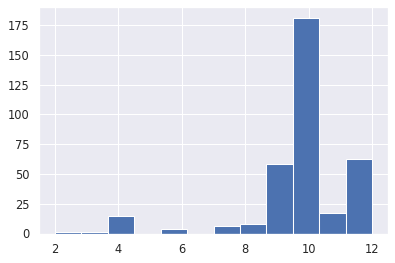

In [122]:
# are they mostly empty?
test.isna().sum(axis=1).hist(bins=12)

In [129]:
# what do the non-empty records look like?
test[test.isna().sum(axis=1) < 8].sort_values(by=['utility_id_ferc1', 'report_year'])

,utility_id_ferc1,report_year,plant_name_original,is_total,construction_year,capacity_mw,peak_demand_mw,net_generation_mwh,total_cost_of_plant,capex_per_mw,opex_total,opex_fuel,opex_maintenance,fuel_type,fuel_cost_per_mmbtu,plant_name_ferc1,plant_type,ferc_license_id,record_id
2670,3,1996,,False,1984.0,9.50,10.0,22210.0,8756400.0,NaN,NaN,NaN,NaN,,NaN,,NaN,NaN,f1_gnrt_plant_1996_12_3_0_26
2869,3,1997,,False,1984.0,9.50,10.0,24230.0,8793178.0,NaN,NaN,NaN,NaN,,NaN,,NaN,NaN,f1_gnrt_plant_1997_12_3_0_26
3764,3,1998,,False,1984.0,9.50,0.0,23910.0,8202810.0,863454.0,163653.0,NaN,166174.0,,NaN,,NaN,NaN,f1_gnrt_plant_1998_12_3_0_26
4863,3,1999,,False,1984.0,9.50,10.0,28610.0,8202810.0,863454.0,239825.0,NaN,166274.0,,NaN,,NaN,NaN,f1_gnrt_plant_1999_12_3_0_13
6070,3,2000,,False,1984.0,9.50,10.0,32110.0,8202810.0,863454.0,303997.0,NaN,129948.0,,NaN,,NaN,NaN,f1_gnrt_plant_2000_12_3_0_13
6320,3,2001,,False,1984.0,9.50,10.0,26060.0,8202810.0,863454.0,289006.0,NaN,93148.0,,NaN,,NaN,NaN,f1_gnrt_plant_2001_12_3_0_13
7120,3,2002,,False,1984.0,9.50,10.0,27190.0,8248506.0,868264.0,309135.0,NaN,134247.0,,NaN,,NaN,NaN,f1_gnrt_plant_2002_12_3_0_13
7589,3,2003,,False,1984.0,9.50,10.0,23310.0,8262660.0,869754.0,305872.0,NaN,129616.0,,NaN,,NaN,NaN,f1_gnrt_plant_2003_12_3_0_13
8153,3,2004,,False,1984.0,8.50,10.0,24480.0,8262660.0,869754.0,335525.0,NaN,80250.0,,NaN,,hydro,NaN,f1_gnrt_plant_2004_12_3_0_13
8921,3,2005,,False,1984.0,8.50,10.0,32280.0,8303688.0,976904.0,337808.0,NaN,107684.0,,NaN,,NaN,NaN,f1_gnrt_plant_2005_12_3_0_13


By looking at the table, I notice that they are concentrated in a handful of specific utilities with weird reporting practices. Maybe to simplify the final notebook, I omit this big table and instead show just the value counts with a note:

In [132]:
# non-empty rows are concentrated mostly in only 2 plants at two utilities
test.loc[test.isna().sum(axis=1) < 8, 'utility_id_ferc1'].value_counts()

3      10
193     9
61      2
94      2
96      1
48      1
84      1
29      1
Name: utility_id_ferc1, dtype: int64

As a reviewer, I might still have questions (why exactly 6 dashes in .contains("------")? etc) but now if I really want to get into the weeds I can just change a value and rerun the cell. As it was before, I had to make all of this myself, all of which was probably duplicating work you already did.

## When we have labeled data, take advantage of sklearn.metrics
I like that you calculated some comparison/performance metrics in your final_touches() function. Scikit-learn has good functions for computing common comparison metrics. They are very helpful to reference when building/designing/iterating models to understand where the weak points are and whether the latest tweak helped or hurt performance.

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

Assumptions:
* manual_map is correct
* is_header is correct
* is_total is correct
* any exclusions are correct

In [67]:
# look only at the "truth": manual labels
compare = assigned_headers.dropna(subset=['manual_map'])
# remove headers (not included in "manual_map") and totals (not included in "header")
compare = compare[~compare['is_header'] & ~compare['is_total']]

sanity check

In [68]:
compare['manual_map'].value_counts()

hydro                  3229
internal_combustion    1802
solar_pv                752
wind                    486
gas_turbine              76
steam_heat               31
fuel_cell                26
diesel_turbine           18
waste_heat               15
coal                     13
pumped_hydro             13
cogen                     3
Name: manual_map, dtype: int64

In [69]:
compare['header'].value_counts()

hydro                  2637
solar_pv                620
internal_combustion     604
diesel_turbine          460
wind                    454
gas_turbine              85
waste_heat               76
steam_heat               44
fuel_cell                19
combustion turbine       14
Name: header, dtype: int64

In [150]:
# Headers had much lower counts. Is that from missing values?
compare['manual_map'].isna().sum()

0

In [71]:
compare['header'].isna().sum()

1451

In [72]:
# nan values don't play nicely with sklearn.metrics
compare.loc[:,'header'] = compare['header'].fillna('NaN')

In [73]:
categories = set(compare['manual_map'].unique()) | set(compare['header'].unique())
len(categories)

14

In [74]:
categories = sorted(list(categories))
categories

['NaN',
 'coal',
 'cogen',
 'combustion turbine',
 'diesel_turbine',
 'fuel_cell',
 'gas_turbine',
 'hydro',
 'internal_combustion',
 'pumped_hydro',
 'solar_pv',
 'steam_heat',
 'waste_heat',
 'wind']

The confusion matrix gives a detailed breakdown of every true vs predicted comparison:

In [ ]:
# rows (indicated with suffix _manual) are True
# columns (_header) are modeled
conf_matrix = pd.DataFrame(confusion_matrix(compare['manual_map'], compare['header'], labels=categories),
                           columns=[label + '_header' for label in categories],
                           index=[label + '_manual' for label in categories])

In [112]:
# if you're re-running this notebook and it errors here, it is because I moved the definition of highlight_diagonal to the bottom of the notebook to avoid distraction.
highlight_diagonal(conf_matrix, color='linen')

,NaN_header,coal_header,cogen_header,combustion turbine_header,diesel_turbine_header,fuel_cell_header,gas_turbine_header,hydro_header,internal_combustion_header,pumped_hydro_header,solar_pv_header,steam_heat_header,waste_heat_header,wind_header
NaN_manual,0,0,0,0,0,0,0,0,0,0,0,0,0,0
coal_manual,2,0,0,0,0,0,0,1,0,0,0,10,0,0
cogen_manual,3,0,0,0,0,0,0,0,0,0,0,0,0,0
combustion turbine_manual,0,0,0,0,0,0,0,0,0,0,0,0,0,0
diesel_turbine_manual,2,0,0,14,0,0,2,0,0,0,0,0,0,0
fuel_cell_manual,0,0,0,0,0,18,0,8,0,0,0,0,0,0
gas_turbine_manual,15,0,0,0,0,0,58,1,1,0,0,0,1,0
hydro_manual,594,0,0,0,1,1,14,2604,12,0,2,0,0,1
internal_combustion_manual,669,0,0,0,457,0,5,6,586,0,9,7,63,0
pumped_hydro_manual,12,0,0,0,0,0,0,0,0,0,0,0,0,1


From the above count data, I can see the main unresolved modeling issues are:
1. still many uncategorized rows
2. conflict between internal combustion and diesel turbine
3. most other discrepancies are small in absolute terms but may be proportionally large

There are probably good reasons for these! Maybe you've hit the point of diminishing returns and all those uncategorized things are one-offs. Maybe the internal combustion vs diesel thing is a result of different definitions. But **as a reviewer, these are the questions I'd like to see explained.**

Finally, the above table can be summarized with various metrics that help give a high level view and provide a relative perspective(rather than absolute counts).

I know you're interested in learning data science stuff, but I don't know where you are in that process. If you already know all this - sorry and please ignore! In case you're unfamiliar, here are some definitions for the table below:
* precision: if the model predicts category X, what fraction are correct? This contains info about false positives.
* recall (aka true positve rate): for true category X, what fraction were correctly modeled as X? This contains info about false negatives.
* f1-score: an attempt to combine precision and recall into a single summary metric by taking their harmonic mean (product divided by sum)
* support: number of data points in category X

Wikipedia has a [good graphical explanation](https://en.wikipedia.org/wiki/Precision_and_recall). There are other related metrics like accuracy, specificity, false positive rate, etc. They are different views on the same information which emphasize different things.

In [77]:
print(classification_report(compare['manual_map'], compare['header'], labels=categories))

                     precision    recall  f1-score   support

                NaN       0.00      0.00      0.00         0
               coal       0.00      0.00      0.00        13
              cogen       0.00      0.00      0.00         3
 combustion turbine       0.00      0.00      0.00         0
     diesel_turbine       0.00      0.00      0.00        18
          fuel_cell       0.95      0.69      0.80        26
        gas_turbine       0.68      0.76      0.72        76
              hydro       0.99      0.81      0.89      3229
internal_combustion       0.97      0.33      0.49      1802
       pumped_hydro       0.00      0.00      0.00        13
           solar_pv       0.98      0.81      0.89       752
         steam_heat       0.61      0.87      0.72        31
         waste_heat       0.11      0.53      0.18        15
               wind       0.94      0.87      0.90       486

           accuracy                           0.67      6464
          macro avg   

/home/tpb/miniconda3/envs/pudl_ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tpb/miniconda3/envs/pudl_ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tpb/miniconda3/envs/pudl_ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

I see generally high precision and lower recall, which indicates a model that prioritizes a low false positive rate.

## In the future, use a train/test split to estimate extrapolation error and overfitting
We have hand labeled data from 2004 - 2015, but we need to categorize data from 1994 to present. Over time, the method of reporting FERC Form 1 has changed (paper -> pdf -> web app), utilities have consolidated, regulators have changed, etc, any of which might change how the data looks and thus have an effect on model performance. We can get an idea of how much of a problem that is by looking at how model performance changes over the course of the labeled data period. It's just an estimate but it's better than nothing.

As an example, we might train the model on labels from 2006 -2013, optimizing the metrics and confusion matrix. Then when we think we have a great model, run it on the test data from 2004/5 and 2014/15. If performance is similar, we can be more confident in our assumption that reporting changes are minor. If performance suffers, maybe we need to label data from different time periods.

Also, when designing/optimizing the model, some rules might work great on the training data but not on other data. Imagine some complicated regex that perfectly picks out 50 plants in the 2006-2013 data, but when applied to 2017 it erroneously includes a bunch of wind plants that didn't exist in 2006. By holding out the test set until after the design process is complete, we can estimate how badly we are 'overfitting'  to the data in front of us and make adjustments.

This is a big topic for another time but something to keep in mind.

In [110]:
# functions to print dataframes differently.
# unfortunately these can't be composed - haven't figured out a fix yet
def format_vertical_headers(df):
    """Display a dataframe with vertical column headers. Useful for gridded data like confusion and correlation matrices"""
    # source: https://stackoverflow.com/questions/46715736/rotating-the-column-name-for-a-panda-dataframe
    styles = [dict(selector="th", props=[('width', '40px')]),
              dict(selector="th.col_heading",
                   props=[("writing-mode", "vertical-rl"),
                          ('transform', 'rotateZ(180deg)'), 
                          ('height', '290px'),
                          ('vertical-align', 'top')])]
    return (df.fillna('').style.set_table_styles(styles))

import numpy as np

def highlight_diagonal(df, color='lightgreen'):
    """ highlight diagonal elements of a dataframe. Useful for symmetric matrices like confusion and correlation matrices"""
    def highlight_diag(df):
        a = np.full(df.shape, '', dtype='<U24')
        np.fill_diagonal(a, f'background-color: {color}')
        return pd.DataFrame(a, index=df.index, columns=df.columns)
    return df.style.apply(highlight_diag, axis=None)